In [1]:
import numpy as np
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
import tensorflow as tf
from ffnn_model import MyFFNN
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import KFold

In [2]:
def process_nn_data(train, test, colNames):
    """Function to process features as input to ffnn model"""
    train.replace([np.inf, -np.inf], np.nan, inplace=True)
    test.replace([np.inf, -np.inf], np.nan, inplace=True)

    train_nn = train[colNames].copy()
    test_nn = test[colNames].copy()

    # 分位数正态分布缩放(连续特征)
    for col in colNames:
        qt = QuantileTransformer(random_state=21, n_quantiles=2000, output_distribution='normal')
        train_nn[col] = qt.fit_transform(train_nn[[col]].values)
        test_nn[col] = qt.transform(test_nn[[col]].values)

    # 缺失值处理(连续特征)
    train_nn[colNames] = train_nn[colNames].fillna(train_nn[colNames].mean())
    test_nn[colNames] = test_nn[colNames].fillna(train_nn[colNames].mean())

    # 离散特征
    train_nn[['stock_id', 'time_id', 'target']] = train[['stock_id', 'time_id', 'target']]
    test_nn[['stock_id', 'time_id']] = test[['stock_id', 'time_id']]

    return train_nn, test_nn

In [3]:
def root_mean_squared_per_error(y_true, y_pred):
    """Function to calculate the root mean squared percentage error in TF"""
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.square((y_true - y_pred) / y_true)))


def train_and_evaluate_nn(train_nn, test_nn, kfold, colNames, hidden_units, output_dim):
    """Function to train FFNN"""
    oof_predictions_nn = np.zeros(train_nn.shape[0])
    test_predictions_nn = np.zeros(test_nn.shape[0])

    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20, verbose=0,
        mode='min', restore_best_weights=True)

    plateau = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=7, verbose=0,
        mode='min')

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_nn[colNames].values)

    input_dim = max(train_nn['stock_id']) + 1  # 必须大于stock_id唯一指的个数
    input_shape = len(colNames)

    model = MyFFNN(input_shape, hidden_units, input_dim, output_dim)

    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_nn)):
        print('CV {}/{}'.format(fold + 1, 5))

        y_train = train_nn.loc[trn_ind, 'target']
        y_test = train_nn.loc[val_ind, 'target']

        num_data = scaler.transform(train_nn.loc[trn_ind, colNames].values)
        num_data_test = scaler.transform(train_nn.loc[val_ind, colNames].values)

        cat_data = train_nn['stock_id'][trn_ind]
        cat_data_test = train_nn['stock_id'][val_ind]

        model.compile(keras.optimizers.Adam(learning_rate=0.006),
                      loss=root_mean_squared_per_error)

        model.fit([cat_data, num_data],
                  y_train,
                  batch_size=2048,
                  epochs=1000,
                  validation_data=([cat_data_test, num_data_test], y_test),
                  callbacks=[es, plateau],
                  validation_batch_size=len(y_test),
                  shuffle=True,
                  verbose=0)

        preds = model.predict([cat_data_test, num_data_test]).reshape(1, -1)[0]
        oof_predictions_nn[val_ind] += preds
        test_predictions_nn += model.predict([test_nn['stock_id'], scaler.transform(test_nn[colNames].values)]).reshape(
            -1, ) / kfold.n_splits
        score = root_mean_squared_per_error(y_true=y_test, y_pred=preds)
        print('Fold {}: {}'.format(fold, score))

    return test_predictions_nn, oof_predictions_nn, model

In [4]:
train_data = pd.read_csv("../../../I_Model/other_AI_model/tabnet_pytorch_tabnet/models/train_dataset.csv", header=0)
test_data = pd.read_csv("../../../I_Model/other_AI_model/tabnet_pytorch_tabnet/models/test_dataset.csv", header=0)

In [5]:
hidden_units = (128, 64, 32)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
colNames = [col for col in list(train_data.columns)
            if col not in {"stock_id", "time_id", "target", "row_id"}]  # 特征列
train_nn, test_nn = process_nn_data(train_data, test_data, colNames)
test_predictions_nn, oof_predictions_nn, model = train_and_evaluate_nn(train_nn, test_nn, kfold,
                                                                       colNames, hidden_units=hidden_units,
                                                                       output_dim=24)

test_predictions_nn

CV 1/5
Fold 0: 0.23829873438316013
CV 2/5
Fold 1: 0.21635569208909428
CV 3/5
Fold 2: 0.21238494077232115
CV 4/5
Fold 3: 0.19982304148092106
CV 5/5
Fold 4: 0.20501913467242436


array([0.00205137, 0.00196698, 0.00196698])

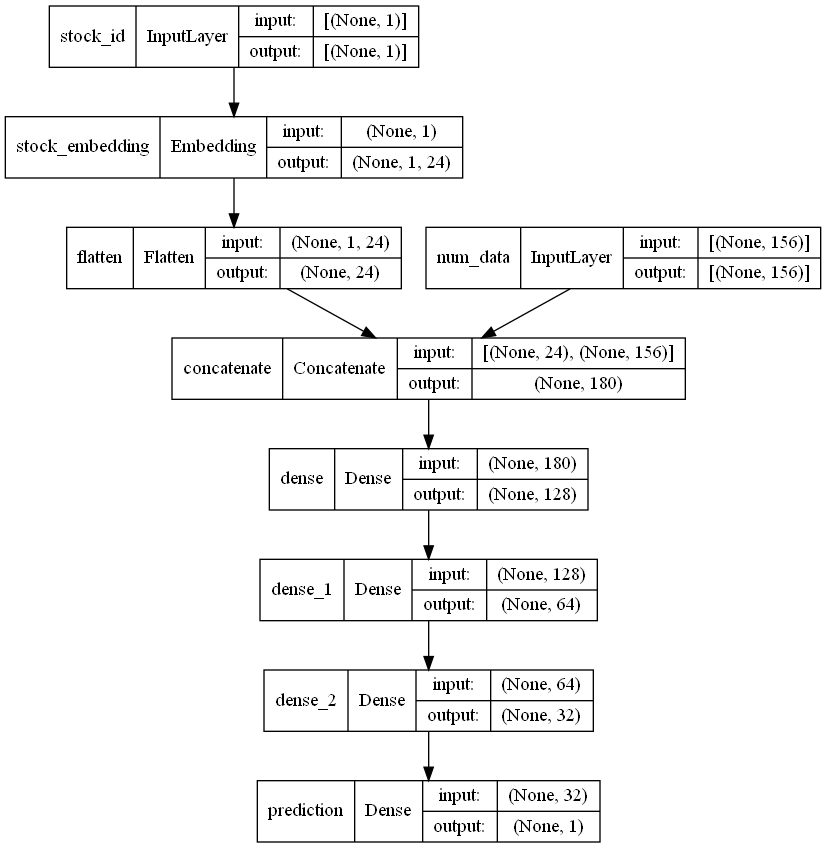

In [6]:
keras.utils.plot_model(model, "ffnn.png", show_shapes=True)

In [7]:
model.weights[0]  # embedding层权重

<tf.Variable 'stock_embedding/embeddings:0' shape=(127, 24) dtype=float32, numpy=
array([[ 3.8849181e-03,  1.3348338e-01,  3.7048697e-02, ...,
         9.5240094e-02,  1.5078598e-03, -1.8379733e-03],
       [-5.5387773e-02,  5.9017859e-02, -6.4081155e-02, ...,
         6.1120436e-02,  8.2237072e-02,  3.0849667e-02],
       [ 2.5461555e-02, -2.5704097e-02,  7.4859135e-02, ...,
        -5.6580972e-02, -8.0953464e-03,  3.8077112e-02],
       ...,
       [-4.8241910e-02,  6.0649890e-02,  9.8977201e-03, ...,
        -3.1121064e-02, -4.9008094e-02, -7.5728565e-02],
       [ 2.7580280e-02, -5.7305105e-02,  8.4720813e-03, ...,
        -3.4803448e-05,  8.4292158e-02,  7.5941950e-02],
       [-5.4594714e-02,  9.7890362e-02, -1.4134803e-01, ...,
        -9.6293218e-02, -3.1195473e-02,  1.0192986e-02]], dtype=float32)>

In [8]:
# stock_id在进行embedding后的特征
stock_id_embedding_feature = tf.gather(model.weights[0], train_nn['stock_id'].values)
stock_id_embedding_feature

<tf.Tensor: shape=(10000, 24), dtype=float32, numpy=
array([[ 0.06036578,  0.12516162,  0.09021981, ..., -0.0724951 ,
         0.09608894,  0.01058095],
       [ 0.03238913, -0.01986424,  0.04300537, ...,  0.03212573,
        -0.03825615,  0.03897357],
       [-0.04427978,  0.12327123,  0.03989104, ..., -0.24142584,
         0.23317477, -0.07159577],
       ...,
       [ 0.04628596,  0.05366861, -0.04782095, ..., -0.02507569,
         0.03573664, -0.1464464 ],
       [-0.05522069,  0.01466324,  0.03605355, ...,  0.03429288,
         0.04722171,  0.09440259],
       [ 0.03910057,  0.05197998, -0.05064408, ...,  0.04620034,
         0.03005279, -0.00653265]], dtype=float32)>

In [9]:
# 使用embedding后的特征可以提高其他算法(KNN、随机森林、lightgbm等)的准确性
stock_id_embedding_feature.shape

TensorShape([10000, 24])